In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import itertools

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import wrangle


In [287]:
# defining a function for explore.py to get lower and upper bounds using IQR method
def get_lower_and_upper_bounds(s, multiplier=1.5):
    """
    This function will
    - accept a numeric series, s; and a float, multipler with the default value of 1.5
    - calculate the lower and upper limit, for example:
        - upper = Q3 + 1.5*IQR
        - lower = Q1 - 1.5*IQR
        - Q1 and Q3 are the quartile values for the 1st/3rd quartiles
        - IQR is the Interquartile range which is Q3-Q1
    - this method works for non-normally distributed data (according to curriculum / Tukey)
    - returns lower_bound and upper_bound
    """
    Q1 = s.quantile(.25)
    Q3 = s.quantile(.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    
    return lower, upper


In [288]:
# this function not used (yet); would go in explore.py
def get_x_sigma_lower_upper(s, sigma_multiplier=3):
    """
    This function will
    - accept a normally-distributed numeric series s, and a float sigma_multiplier with default value 3
    - calculate lower and upper using +- sigma_multiplier * standard deviation
    - return lower, upper
    """
    sigma = s.std()
    mean_ = s.mean()
    lower = mean_ - sigma * sigma_multiplier
    upper = mean_ + sigma * sigma_multiplier
    return lower, upper

In [3]:
df = wrangle.wrangle_curriculum_logs()

In [4]:
df.head()

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,javascript-i/introduction/working-with-data-ty...,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/functions,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


# EXPLORE

In [7]:
pages = df.resample('d').endpoint.count()

In [8]:
pages

date
2018-01-26     572
2018-01-27     230
2018-01-28     170
2018-01-29     830
2018-01-30     652
              ... 
2021-04-17     478
2021-04-18     659
2021-04-19    2156
2021-04-20    1930
2021-04-21    1131
Freq: D, Name: endpoint, Length: 1182, dtype: int64

## Q1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
## Q7. (closely related) Which lessons are least accessed?

In [302]:
# defining a function to get the top or bottom page counts by program
def get_top_pages_by_program(df, number=5, bottom=False):
    """
    This function will 
    - accept a df from wrangle_curriculum_logs and a boolean top (True if user wants top 5, False if bottom 5)
    - print out the top or bottom 5 most accessed pages per program
    - returns nothing
    """
    # 50313 rows with '/' as the endpoint. This is what the text file has.
    # I will ignore these for the sake of exploration
    
    # get a count of the unique program_id - endpoint combinations
    endpoints_by_program = df[df.endpoint != '/'].groupby(['program_id', 'endpoint']).endpoint.count()
    # make a list of program_ids to iterate over
    program_id_list = sorted(df.program_id.unique())

    if bottom:
        top_or_bottom = 'Bottom'
    else:
        top_or_bottom = 'Top'
    # printing the top/bottom programs in each of the program ids
    for id in program_id_list:
        print (f'{top_or_bottom} {number} page access counts for program {id}: ')
        print (endpoints_by_program.loc[id].sort_values(ascending = bottom).head(number))
        print('---------------------------')

## What program_id corresponds to what program?

In [303]:
# (exploration below) program_id's 
# 0: Unknown
# 1: WebDev - 
# 2: WebDev - 
# 3: Data Science - San Antonio
# 4: Apollo cohort only??

In [304]:
get_top_pages_by_program(df)

Top 5 page access counts for program 0: 
endpoint
search/search_index.json    1985
javascript-i                 780
toc                          706
spring                       641
java-iii                     567
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 1: 
endpoint
index.html      1011
javascript-i     736
html-css         542
spring           501
java-iii         479
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 2: 
endpoint
javascript-i                17457
toc                         17428
search/search_index.json    15212
java-iii                    12683
html-css                    12569
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 3: 
endpoint
search/search_index.json                    2203
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg      

## Summary Question 1 (Which lesson appears to attract the most traffic consistently acrtoss cohorts (per program)?
- program_id 1 (WebDev): javascript-i is the most accessed lesson
- program_id 2 (WebDev): javascript-i is the most accessed lesson
- program_id 3 (Data Science): classification/overview is the most accessed lesson
- program_id 4 (Apollo cohort??): only 4 rows in the dataset: content/html-css is the most accessed
- program_id 0 (UNKNOWN): javascript-i is the most accessed lesson

# Question 7: Which lessons are least accessed?

In [306]:
get_top_pages_by_program(df, 10, bottom=True)

Bottom 10 page access counts for program 0: 
endpoint
fundamentals/DataToAction_v2.jpg              1
7-classification/ensemble                     1
content/git/initializing-a-repository.html    1
7-classification/confusion-matrix             1
7-classification/6.4-knn                      1
MachineLearning_CheatSheet                    1
7-classification/5-explore                    1
7-classification/5-evaluation                 1
7-classification/4-explore                    1
Python_Libraries                              1
Name: endpoint, dtype: int64
---------------------------
Bottom 10 page access counts for program 1: 
endpoint
html-css/media-queries                               1
content/jquery/events/keyboard-events.html           1
content/jquery/events/gitbook/images/favicon.ico     1
content/jquery/events                                1
content/jquery/essential-methods/traversing.html     1
content/jquery/effects/gitbook/images/favicon.ico    1
content/jquery/effects/an

In [307]:
# Since so many lessons were only accessed 1 time, let me ask for that
pages = df.endpoint.value_counts()
pages[pages==1].shape

(457,)

## Summarize Q7 - Which lessons are least accessed?
- 457 pages were accessed only once in the dataset
- It is unknown how many pages were not accessed at all as that info is not in the dataset
- Of the 457 pages accessed only once, here are a few trends by program. (This will take some more analysis):
    - program_id 1 (WebDev): jquery pages are low-access
    - program_id 2 (WebDev): cli pages are low-access
    - program_id 3 (Data Science): storytelling, classification
    - program_id 4 (Apollo cohort??): only 4 rows in the dataset: content/html-css is the most accessed
    - program_id 0 (UNKNOWN): classification lessons are low-access

# Question 2: Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

In [309]:
# defining a function to get lower and upper bounds and compare pages across cohorts
def get_mismatch_pages(df, multiplier=3):
    """
    This function will
    - accept a dataframe from wrangle_curriculum_logs, preferably separated by program_id to reduce 
       runtime and for results readability
    - looks for high/low page visits per cohort
    - returns a dataframe of pages that were visited a lot by some cohorts by very litte by other cohorts
    """
    # initialize lists for top and bottom page counts
    top_page_list = []
    bottom_page_list = []
    # loop through cohorts
    for c_name in df.name.unique():
        # get the page counts for each cohort
        cohort_pages = df[df.name == c_name].endpoint.value_counts()
        # get the lower, upper bounds of page counts using IQR multiplier of 3
        lower, upper = get_lower_and_upper_bounds(cohort_pages, multiplier)
        # add top pages to top_page_list
        top_page_list += list(cohort_pages[cohort_pages > upper].index)
        # lower is < 0, so just add pages that only had a few hits (for now 1)
        bottom_page_list += list(cohort_pages[cohort_pages <= 1].index)
        
    # initialize a list of the bottom pages that are found in the top pages
    # this will tell me what pages are glossed over by one cohort that are higher views in other cohorts
    bottom_in_top_list = []
    for p in bottom_page_list:
        if p in top_page_list:
            bottom_in_top_list.append(p)
            
    name_list = list(df.name.unique())
    columns = ['endpoint'] + name_list
    
    ## Debugging
    # return bottom_in_top_list
    
    
    # get a value_counts by cohort for each of the pages on the bottom_in_top_list
    # first initialize a df
    mismatch_pages_df = pd.DataFrame(columns=columns)
    # for each page in the bottom_in_top_list, see what the page count is for each cohort & add it to mismatch_pages_df
    for p in bottom_in_top_list:
        p_count_list = []
        for cohort in mismatch_pages_df.columns[1:]:
            p_count = df[(df.name == cohort) & (df.endpoint == p)].endpoint.count()
            p_count_list.append(p_count)
        new_entry = [p] + p_count_list
        mismatch_pages_df.loc[len(mismatch_pages_df)] = new_entry
        
    return mismatch_pages_df

In [432]:
## After exploring, we decided to just look at a subset of the data that includes classes
# that were active during the timespan of the data we have to better understand class activity
## Get all the rows that are part of classes that started
# after the start of our data and ended before the end of our data
subset_df = df[(df.start_date >= df.index[0].strftime(format='%Y-%m-%d')) &
               (df.end_date <= df.index[len(df)-1].strftime(format='%Y-%m-%d'))]

In [433]:
# break up subset_df into programs (1,2 are webdev, 3 is data science)
p12_df = subset_df[subset_df['program_id'].isin([1,2])]
p3_df = subset_df[subset_df.program_id == 3]

In [434]:
get_mismatch_pages(p12_df)

,endpoint,Ulysses,Voyageurs,Wrangell,Xanadu,Yosemite,Zion,Andromeda,Betelgeuse,Ceres,Deimos,Europa,Fortuna,Apex,Ganymede,Hyperion,Bash,Jupiter


In [435]:
get_mismatch_pages(p3_df)

,endpoint,Bayes,Curie,Darden
0,4-python/7.4.4-advanced-dataframes,219,1,0
1,9-timeseries/4-explore,212,109,1


## Summary Question 2 (Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over
- 2 pages popped up
    - The advanced-dataframes lesson was accessed a lot by Bayes, but very little by Curie and Darden
    - The Timeseries explore lesson was accessed a lot by Bayes and Curie, but very little by Darden

# Question 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [378]:
def get_in_class_low_access_users(df, limit=10):
    """
    This function will 
    - accept the dataframe from wrangle_curriculum_logs
    - accept a limit, which is the max number of page access's for a user, default value = 10
    - returns a dataframe of all page accesses for user_ids that <= number of page access's given in limit
    """
    # first extract from the df only those page accesses that occurred during a user's class start and end dates
    in_class_access_df = df[(df.index>=df.start_date) & (df.index<=df.end_date)]
    # get value_counts of users (number of page accesses per user)
    in_class_user_page_counts = in_class_access_df.user_id.value_counts()
    # get only the users that, while in class, accessed curriculum pages <= 'limit' times
    low_access_in_class = in_class_user_page_counts[in_class_user_page_counts<=limit]
    # get all page accesses by users who accessed the curriculum <= limit times
    results_df = in_class_access_df[in_class_access_df['user_id'].isin(low_access_in_class.index)]
    
    return results_df

In [382]:
# for demonstration, just pulling the userids who only accessed the curriculum
# one time while they were in class
get_in_class_low_access_users(df, 1)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2020-03-23,/,619,57,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2
2021-01-26,/,879,135,136.50.50.187,Marco,2021-01-25,2021-07-19,2
2021-03-15,/,940,138,70.121.129.79,Neptune,2021-03-15,2021-09-03,2
2021-03-15,/,918,138,71.221.46.112,Neptune,2021-03-15,2021-09-03,2


## Summary of Q3, Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
- There are 10 users in the dataset who, while active, accessed the curriculum <= 10 times
    - All users were in program 2
    - They were in 9 separate cohorts (2 users in the same cohort)
- Seven of the ten users accessed the curriculum on the first or second day of class only, indicating students who may have dropped out
- 3 of the 10 accessed the curriculum much later in the program
    - User 278, 812, 832 from Voyageurs, Hyperion, and Jupiter cohorts respectively
    - No good explanation for this: could be an error in capturing the data or some sort of unauthorized access


# ---------  BREAK BREAK -------------
- messy exploration below, Above is the stuff for copying to final_report

In [73]:
# 50313 rows with '/' as the endpoint. This is what the text file has.
# I will ignore these for the sake of exploration
df[df.endpoint == '/'].sample(2)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2019-12-16,/,440,33,216.82.131.133,Ceres,2019-07-15,2019-12-11,2
2021-04-12,/,975,139,68.203.215.174,Oberon,2021-04-12,2021-10-01,2


In [126]:
# get a count of the unique program_id - endpoint combinations
endpoints_by_program = df[df.endpoint != '/'].groupby(['program_id', 'endpoint']).endpoint.count()

In [127]:
endpoints_by_program

program_id  endpoint                                   
0           00_                                             8
            00_index                                       20
            01_intro                                       44
            02_listing_files                               39
            03_file_paths                                  38
                                                           ..
3           where                                           1
            working-with-time-series-data                  14
4           content/html-css                                2
            content/html-css/gitbook/images/favicon.ico     1
            content/html-css/introduction.html              1
Name: endpoint, Length: 4416, dtype: int64

In [128]:
# make a list of program_ids to iterate over
program_id_list = sorted(df.program_id.unique())
program_id_list

[0, 1, 2, 3, 4]

In [116]:
# printing the top 5 programs in each of the program ids
for id in program_id_list:
    print (f'Top 5 page access counts for program {id}: ')
    print (endpoints_by_program.loc[id].sort_values(ascending = False).head(5))
    print('---------------------------')

Top 5 page access counts for program 0: 
endpoint
search/search_index.json    1985
javascript-i                 780
toc                          706
spring                       641
java-iii                     567
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 1: 
endpoint
index.html      1011
javascript-i     736
html-css         542
spring           501
java-iii         479
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 2: 
endpoint
javascript-i                17457
toc                         17428
search/search_index.json    15212
java-iii                    12683
html-css                    12569
Name: endpoint, dtype: int64
---------------------------
Top 5 page access counts for program 3: 
endpoint
search/search_index.json                    2203
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg      

## What program_id corresponds to what program?

In [ ]:
# program 3 is definitely data science.
# program 0 is the value for when program_id was null
# program 4 only has 5 rows, so hard to determine, but we'll look a little more later
# what about program 1 and 2

In [119]:
# get the top 20 pages for program 1
print (endpoints_by_program.loc[1].sort_values(ascending = False).head(20))

endpoint
index.html                                                                   1011
javascript-i                                                                  736
html-css                                                                      542
spring                                                                        501
java-iii                                                                      479
java-ii                                                                       454
java-i                                                                        444
javascript-ii                                                                 429
appendix                                                                      409
jquery                                                                        344
mysql                                                                         284
content/html-css                                                              262
javascr

In [120]:
# program 1 looks a lot like web dev. Let's check index (dates) for accesses 
# for program 1 and 2

In [121]:
df[df.program_id == 1].head(5)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,/,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1
2018-01-26,javascript-i/conditionals,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1
2018-01-26,javascript-i,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1
2018-01-26,/,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1


In [122]:
df[df.program_id == 2].head(5)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,javascript-i/introduction/working-with-data-ty...,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/functions,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/introduction/variables,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [125]:
df[df.program_id == 4]

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-03-22,content/html-css/introduction.html,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,content/html-css,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,content/html-css/gitbook/images/favicon.ico,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,content/html-css,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,/,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4


In [124]:
df[df.name == 'Apollo']

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-03-22,content/html-css/introduction.html,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,content/html-css,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,content/html-css/gitbook/images/favicon.ico,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,content/html-css,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4
2018-03-22,/,152,9,207.68.209.17,Apollo,2015-03-30,2015-07-29,4


In [123]:
# So it looks like this
# 0: Unknown
# 1: WebDev - 
# 2: WebDev - 
# 3: Data Science - San Antonio
# 4: Apollo cohort only??

In [129]:
df[df.program_id == 0].shape

(52893, 8)

In [130]:
df.shape

(900223, 8)

In [131]:
df.program_id.value_counts(normalize=True)

2    0.792431
3    0.114874
0    0.058755
1    0.033934
4    0.000006
Name: program_id, dtype: float64

## Summary Question 1 (Which lesson appears to attract the most traffic consistently acrtoss cohorts (per program)?
- program_id 1 (WebDev): javascript-i is the most accessed lesson
- program_id 2 (WebDev): javascript-i is the most accessed lesson
- program_id 3 (Data Science): classification/overview is the most accessed lesson
- program_id 4 (Apollo cohort??): only 4 rows in the dataset: content/html-css is the most accessed
- program_id 0 (UNKNOWN): javascript-i is the most accessed lesson

# Question 7: Which lessons are least accessed?

In [133]:
# printing the bottom 5 programs in each of the program ids
for id in program_id_list:
    print (f'Bottom 5 page access counts for program {id}: ')
    print (endpoints_by_program.loc[id].sort_values(ascending = False).tail(10))
    print('---------------------------')

Bottom 5 page access counts for program 0: 
endpoint
content/php_i/types-and-variables-i/introduction-to-strings.html            1
content/php_ii/control-structures-i/gitbook/images/favicon.ico              1
content/php_ii/array-functions/gitbook/images/favicon.ico                   1
content/php_ii/array-functions                                              1
content/php_i/types-and-variables-ii/objects-other-types-and-review.html    1
content/php_i/types-and-variables-ii/intro-to-arrays.html                   1
content/php_i/types-and-variables-ii/gitbook/images/favicon.ico             1
content/php_i/types-and-variables-ii/constants.html                         1
content/php_i/types-and-variables-i/type-juggling-and-booleans.html         1
5-regression/4-multivariate-regression-in-excel                             1
Name: endpoint, dtype: int64
---------------------------
Bottom 5 page access counts for program 1: 
endpoint
Intro_to_Regression                                  1
9.

In [164]:
# Since so many lessons were only accessed 1 time, let me ask for that
temp = df.endpoint.value_counts()
low = temp[temp == 1]
low

index                                                           1
team                                                            1
data-science-pipeline                                           1
evaluate                                                        1
javascript-i/intruduction/operators                             1
                                                               ..
4-python                                                        1
4-python/overview                                               1
prework/cli/07-editing-files-with-vim                           1
12-distributed-ml/6.4-prepare-part-4                            1
appendix/professional-development/post-interview-review-form    1
Name: endpoint, Length: 457, dtype: int64

In [174]:
low_series = pd.Series(low.index)
low_df = pd.DataFrame(low_series, columns=['endpoint'])
low_df.head(2)

,endpoint
0,index
1,team


In [195]:
low_df.sample(10)

,endpoint
54,nlp
206,learn-to-code
419,students/882/EDIT
164,team-setups
71,bom-and-dom/dom-events
82,content/loops.html
381,6-regression/2-intro-to-regression
450,appendix/testing-code.md
304,appendix/further-reading/flexbox-additional-co...
60,javascri


In [194]:
low_df.endpoint.str.contains('stat').sum()

24

## Summarize Q7 - Which lessons are least accessed?
- 457 pages were accessed only once in the dataset
- It is unknown how many pages were not accessed at all as that info is not in the dataset
- Of the 457 pages accessed only once, trends include pages with these words in the title:
    - appendix
    - css
    - java
    - javascript
    - exercise
    - intro
    - regression
    - cli
    - stat

# Question 2: Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

In [207]:
# putting the program ids into separate dataframes
p0_df = df[(df.program_id == 0) & (df.endpoint != '/')]
p1_df = df[(df.program_id == 1) & (df.endpoint != '/')]
p2_df = df[(df.program_id == 2) & (df.endpoint != '/')]
p3_df = df[(df.program_id == 3) & (df.endpoint != '/')]
p4_df = df[(df.program_id == 4) & (df.endpoint != '/')]

In [220]:
# starting with id 3 (Data Science) because it is the smallest
p3_df.name.value_counts()

Darden      29035
Bayes       24571
Curie       19870
Easley      13600
Florence     7978
Name: name, dtype: int64

In [217]:
# what are the top pages for the Bayes cohort?
p3_df[p3_df.name == 'Bayes'].endpoint.value_counts().head()

1-fundamentals/modern-data-scientist.jpg    650
1-fundamentals/AI-ML-DL-timeline.jpg        648
1-fundamentals/1.1-intro-to-data-science    640
search/search_index.json                    588
6-regression/1-overview                     521
Name: endpoint, dtype: int64

In [221]:
# what are the top and bottom pages for each DS cohort?
for c_name in p3_df.name.unique():
    print(f'Top 5 pages for cohort {c_name}:')
    print(p3_df[p3_df.name == c_name].endpoint.value_counts().head())
    print()
    print(f'Bottom 5 pages for cohort {c_name}:')
    print(p3_df[p3_df.name == c_name].endpoint.value_counts().tail())
    print('-----------------------------------------------')

Top 5 pages for cohort Bayes:
1-fundamentals/modern-data-scientist.jpg    650
1-fundamentals/AI-ML-DL-timeline.jpg        648
1-fundamentals/1.1-intro-to-data-science    640
search/search_index.json                    588
6-regression/1-overview                     521
Name: endpoint, dtype: int64

Bottom 5 pages for cohort Bayes:
spring/extra-features/error-pages/asdfasdf    1
javascript-i/bom-and-dom/dom                  1
capstones                                     1
mkdocs/search_index.json                      1
fundamentals/cli/overview                     1
Name: endpoint, dtype: int64
-----------------------------------------------
Top 5 pages for cohort Curie:
6-regression/1-overview                     595
search/search_index.json                    538
1-fundamentals/modern-data-scientist.jpg    467
1-fundamentals/AI-ML-DL-timeline.jpg        465
1-fundamentals/1.1-intro-to-data-science    461
Name: endpoint, dtype: int64

Bottom 5 pages for cohort Curie:
search           

In [222]:
p3_df.head()

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2019-08-20,1-fundamentals/1.3-pipeline-demo,479,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/DataToAction_v2.jpg,479,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/1.2-data-science-pipeline,479,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/AI-ML-DL-timeline.jpg,479,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/modern-data-scientist.jpg,479,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3


In [281]:
# defining a function to get lower and upper bounds and compare pages across cohorts
def get_mismatch_pages(df, multiplier=3):
    """
    This function will
    - accept a dataframe from wrangle_curriculum_logs, preferably separated by program_id
    - looks for high/low page visits per cohort
    - returns a dataframe of pages that were visited a lot by some cohorts by very litte by other cohorts
    """
    # initialize lists for top and bottom page counts
    top_page_list = []
    bottom_page_list = []
    # loop through cohorts
    for c_name in df.name.unique():
        # get the page counts for each cohort
        cohort_pages = df[df.name == c_name].endpoint.value_counts()
        # get the lower, upper bounds of page counts using IQR multiplier of 3
        lower, upper = get_lower_and_upper_bounds(cohort_pages, multiplier)
        # add top pages to top_page_list
        top_page_list += list(cohort_pages[cohort_pages > upper].index)
        # lower is < 0, so just add pages that only had a few hits (for now 1)
        bottom_page_list += list(cohort_pages[cohort_pages <= 1].index)
        
    # initialize a list of the bottom pages that are found in the top pages
    # this will tell me what pages are glossed over by one cohort that are higher views in other cohorts
    bottom_in_top_list = []
    for p in bottom_page_list:
        if p in top_page_list:
            bottom_in_top_list.append(p)
            
    name_list = list(df.name.unique())
    columns = ['endpoint'] + name_list
    
    ## Debugging
    # return bottom_in_top_list
    
    
    # get a value_counts by cohort for each of the pages on the bottom_in_top_list
    # first initialize a df
    mismatch_pages_df = pd.DataFrame(columns=columns)
    # for each page in the bottom_in_top_list, see what the page count is for each cohort & add it to mismatch_pages_df
    for p in bottom_in_top_list:
        p_count_list = []
        for cohort in mismatch_pages_df.columns[1:]:
            p_count = df[(df.name == cohort) & (df.endpoint == p)].endpoint.count()
            p_count_list.append(p_count)
        new_entry = [p] + p_count_list
        mismatch_pages_df.loc[len(mismatch_pages_df)] = new_entry
        
    return mismatch_pages_df

In [282]:
get_mismatch_pages(p3_df)

,endpoint,Bayes,Curie,Darden,Easley,Florence
0,4-python/7.4.4-advanced-dataframes,219,1,0,0,0
1,9-timeseries/5.1-modeling-lesson1,188,64,1,0,0
2,9-timeseries/4-explore,212,109,1,0,0
3,8-clustering/4-explore,192,97,1,0,0
4,7-classification/project,248,158,2,1,0
5,appendix/cli-git-overview,311,190,78,1,0
6,3-sql/1-mysql-overview,143,441,122,1,0
7,classification/explore,28,16,352,186,1


In [283]:
get_mismatch_pages(p1_df)

,endpoint,Arches,Quincy,Hampton,Kings,Lassen,Glacier,Denali,Joshua,Olympic,Badlands,Ike,Franklin
0,index.html,1,6,1,84,877,0,0,8,28,0,6,0
1,content/laravel/quickstart/eloquent-orm.html,1,2,1,29,6,0,0,0,1,0,0,0
2,content/laravel/quickstart/resource-controller...,1,3,0,39,11,0,0,0,1,0,0,0
3,content/javascript,1,5,3,37,36,8,0,12,30,0,3,0
4,javascript-i/introduction/working-with-data-ty...,71,1,9,4,57,24,0,0,65,0,1,0
5,javascript-i/introduction/variables,44,1,2,1,35,19,0,0,42,0,1,0
6,javascript-i/javascript-with-html,76,1,9,5,54,14,0,0,63,0,2,1
7,jquery,133,1,26,2,102,3,0,0,71,0,4,2
8,content/html-css/introduction.html,4,8,1,28,34,20,0,14,35,1,4,0
9,content/html-css,9,33,1,45,59,29,0,19,57,1,9,0


In [285]:
##### to display all columns (df.head())
pd.set_option('display.max_columns', None)

In [286]:
p2_mm_df = get_mismatch_pages(p2_df)
p2_mm_df.head()

,endpoint,Teddy,Sequoia,Pinnacles,Niagara,Mammoth,Ulysses,Voyageurs,Wrangell,Xanadu,Yosemite,Staff,Zion,Andromeda,Betelgeuse,Ceres,Deimos,Europa,Fortuna,Apex,Ganymede,Hyperion,Bash,Jupiter,Kalypso,Luna,Marco,Neptune,Oberon
0,sql/mysql-overview,1,0,0,0,0,0,0,0,0,0,821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,classification/scale_features_or_not.svg,1,0,0,0,0,0,0,0,0,0,707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,classification/overview,1,0,0,0,0,0,0,0,0,0,851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,appendix/cli-git-overview,1,1,0,0,0,0,1,0,0,0,367,0,0,6,5,0,0,0,0,0,0,0,0,0,0,0,0,0
4,html-css/css-i/grid/css-grid-fundamentals,1,1,1,0,0,0,0,0,28,0,164,13,3,8,305,249,214,217,186,218,17,5,14,2,3,8,0,0


In [275]:
p2_df.shape

(677551, 8)

In [278]:
p2_df.name.value_counts()

Staff         77691
Ceres         39077
Zion          36298
Jupiter       35413
Fortuna       34864
Voyageurs     33535
Apex          32222
Ganymede      32117
Deimos        31421
Teddy         29098
Hyperion      28490
Betelgeuse    28401
Ulysses       26893
Xanadu        26825
Europa        26738
Wrangell      24454
Andromeda     24185
Kalypso       22752
Yosemite      19762
Bash          16941
Luna          16132
Marco         15698
Sequoia        6814
Neptune        6804
Pinnacles      2009
Oberon         1541
Niagara         718
Mammoth         658
Name: name, dtype: int64

In [276]:
p2_mm_list = get_mismatch_pages(p2_df)

In [279]:
p2_mm_list

['sql/mysql-overview',
 'classification/scale_features_or_not.svg',
 'classification/overview',
 'appendix/cli-git-overview',
 'html-css/css-i/grid/css-grid-fundamentals',
 '3-sql/1-mysql-overview',
 '6-regression/1-overview',
 'html-css/css-i/grid/css-grid-fundamentals',
 '1._Fundamentals',
 '3.0-mysql-overview',
 'appendix/cli-git-overview',
 'spring/fundamentals/integration-tests',
 'java-ii/dependency-management',
 '1._Fundamentals',
 'mysql/clauses/limit',
 'html-css/css-i/grid/css-grid-fundamentals',
 'java-ii/exceptions-and-error-handling',
 'java-ii/annotations',
 'jquery/essential-methods/attributes-and-css',
 'javascript-i/bom-and-dom/dom-events',
 'jquery/essential-methods/attributes-and-css',
 'javascript-i/conditionals',
 'appendix/capstone-workbook',
 'java-ii/object-oriented-programming',
 'html-css/css-ii/bootstrap-introduction',
 'java-iii/user-input',
 'html-css/css-ii/media-queries',
 'java-ii/inheritance-and-polymorphism',
 'javascript-i/functions',
 'mysql/clauses/

In [233]:
# initialize lists for top and bottom page counts
top_page_list = []
bottom_page_list = []
# loop through cohorts
for c_name in p3_df.name.unique():
    # get the page counts for each cohort
    cohort_pages = p3_df[p3_df.name == c_name].endpoint.value_counts()
    # get the lower, upper bounds of page counts using IQR multiplier of 3
    lower, upper = get_lower_and_upper_bounds(cohort_pages, 3)
    # print statement for function building
    print (f'cohort {c_name}, lower: {lower}, upper: {upper}')
    # add top pages to top_page_list
    top_page_list += list(cohort_pages[cohort_pages > upper].index)
    # lower is < 0, so just add pages that only had a few hits (for now 1)
    bottom_page_list += list(cohort_pages[cohort_pages <= 1].index)

cohort Bayes, lower: -117.25, upper: 161.0
cohort Curie, lower: -195.0, upper: 267.0
cohort Darden, lower: -258.0, upper: 351.0
cohort Easley, lower: -279.0, upper: 379.0
cohort Florence, lower: -200.0, upper: 269.0


In [234]:
# initialize a list of the bottom pages that are found in the top pages
# this will tell me what pages are glossed over by one cohort that are higher views in other cohorts
bottom_in_top_list = []
for p in bottom_page_list:
    if p in top_page_list:
        print (p)
        bottom_in_top_list.append(p)

4-python/7.4.4-advanced-dataframes
9-timeseries/5.1-modeling-lesson1
9-timeseries/4-explore
8-clustering/4-explore
7-classification/project
appendix/cli-git-overview
3-sql/1-mysql-overview
classification/explore


In [238]:
name_list = list(p3_df.name.unique())
columns = ['endpoint'] + name_list
columns

['endpoint', 'Bayes', 'Curie', 'Darden', 'Easley', 'Florence']

In [256]:
# get a value_counts by cohort for each of the pages on the bottom_in_top_list

# first initialize a df
mismatch_pages_df = pd.DataFrame(columns=columns)
# for each page in the bottom_in_top_list, see what the page count is for each cohort & add it to mismatch_pages_df
for p in bottom_in_top_list:
    p_count_list = []
    for cohort in mismatch_pages_df.columns[1:]:
        p_count = p3_df[(p3_df.name == cohort) & (p3_df.endpoint == p)].endpoint.count()
        p_count_list.append(p_count)
    new_entry = [p] + p_count_list
    mismatch_pages_df.loc[len(mismatch_pages_df)] = new_entry

In [257]:
mismatch_pages_df

,endpoint,Bayes,Curie,Darden,Easley,Florence
0,4-python/7.4.4-advanced-dataframes,219,1,0,0,0
1,9-timeseries/5.1-modeling-lesson1,188,64,1,0,0
2,9-timeseries/4-explore,212,109,1,0,0
3,8-clustering/4-explore,192,97,1,0,0
4,7-classification/project,248,158,2,1,0
5,appendix/cli-git-overview,311,190,78,1,0
6,3-sql/1-mysql-overview,143,441,122,1,0
7,classification/explore,28,16,352,186,1


In [ ]:
### Looking at all endpoints not grouped by program_id
# get value_counts of all the unique endpoints which are not '/'
endpoint_cnts = df[df.endpoint != '/'].endpoint.value_counts()

In [109]:
endpoint_cnts.describe()

count     2312.000000
mean       367.607699
std       1383.726479
min          1.000000
25%          2.000000
50%         12.000000
75%        130.250000
max      19519.000000
Name: endpoint, dtype: float64

<AxesSubplot:>

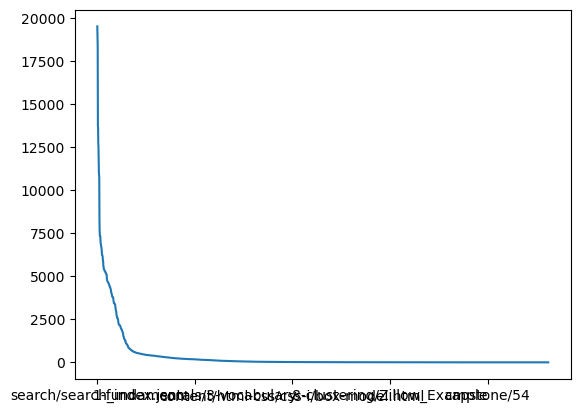

In [110]:
# plot endpoint_cnts
endpoint_cnts.plot()

In [111]:
# using function to decide what the lower / upper bounds should be using IQR method with multiplier = 3
lower, upper = get_lower_and_upper_bounds(endpoint_cnts, 3)
lower, upper

(-382.75, 515.0)

In [112]:
# how many are above the upper limit?
endpoint_cnts[endpoint_cnts > upper].shape

(217,)

In [115]:
# these are the top 5 pages across all programs
endpoint_cnts[endpoint_cnts > upper].head(8)

search/search_index.json    19519
javascript-i                18983
toc                         18297
java-iii                    13733
html-css                    13635
java-ii                     12685
spring                      12524
jquery                      11525
Name: endpoint, dtype: int64

# Question 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [378]:
def get_in_class_low_access_users(df, limit=10):
    """
    This function will 
    - accept the dataframe from wrangle_curriculum_logs
    - accept a limit, which is the max number of page access's for a user, default value = 10
    - returns a dataframe of all page accesses for user_ids that <= number of page access's given in limit
    """
    # first extract from the df only those page accesses that occurred during a user's class start and end dates
    in_class_access_df = df[(df.index>=df.start_date) & (df.index<=df.end_date)]
    # get value_counts of users (number of page accesses per user)
    in_class_user_page_counts = in_class_access_df.user_id.value_counts()
    # get only the users that, while in class, accessed curriculum pages <= 'limit' times
    low_access_in_class = in_class_user_page_counts[in_class_user_page_counts<=limit]
    # get all page accesses by users who accessed the curriculum <= limit times
    results_df = in_class_access_df[in_class_access_df['user_id'].isin(low_access_in_class.index)]
    
    return results_df

In [382]:
# for demonstration, just pulling the userids who only accessed the curriculum
# one time while they were in class
get_in_class_low_access_users(df, 1)

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2020-03-23,/,619,57,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2
2021-01-26,/,879,135,136.50.50.187,Marco,2021-01-25,2021-07-19,2
2021-03-15,/,940,138,70.121.129.79,Neptune,2021-03-15,2021-09-03,2
2021-03-15,/,918,138,71.221.46.112,Neptune,2021-03-15,2021-09-03,2


## Summary of Q3, Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
- There are 10 users in the dataset who, while active, accessed the curriculum <= 10 times
    - All users were in program 2
    - They were in 9 separate cohorts (2 users in the same cohort)
- Seven of the ten users accessed the curriculum on the first or second day of class only, indicating students who may have dropped out
- 3 of the 10 accessed the curriculum much later in the program
    - User 278, 812, 832 from Voyageurs, Hyperion, and Jupiter cohorts respectively
    - No good explanation for this: could be an error in capturing the data or some sort of unauthorized access


In [319]:
df.head()

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,javascript-i/introduction/working-with-data-ty...,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/functions,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [331]:
# this is the number of times each user id accessed any page in the curriculum
user_id_page_access_counts = df.user_id.value_counts()
user_id_page_access_counts

11     17913
64     16347
53     12329
314     7783
1       7404
       ...  
66         1
619        1
649        1
652        1
879        1
Name: user_id, Length: 981, dtype: int64

In [349]:
in_class_access_df = df[(df.index>=df.start_date) & (df.index<=df.end_date)]
in_class_access_df.head()

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-01-26,javascript-i/introduction/working-with-data-ty...,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,39,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/javascript-with-html,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/functions,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/introduction/variables,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [350]:
# 644386 page accesses occurred for user_id's that were in class
in_class_access_df.shape

(647496, 8)

In [341]:
# all staff members have a start and end_date of 2014-02-04, so no staff pulls are in the above df
df[(df.name == 'Staff') & (df.start_date != '2014-02-04')].head()
df[(df.name == 'Staff') & (df.end_date != '2014-02-04')].head()

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,


In [351]:
in_class_user_page_counts = in_class_access_df.user_id.value_counts()

In [352]:
#731 users that accessed pages during their class dates
in_class_user_page_counts.shape

(731,)

In [366]:
# 10 users, while in class, accessed curriculum pages <= 10 times
low_access_in_class = in_class_user_page_counts[in_class_user_page_counts<=10]
low_access_in_class

388    8
812    7
956    6
539    5
278    4
832    3
918    1
879    1
940    1
619    1
Name: user_id, dtype: int64

In [374]:
# these are all the page accesses by users who accessed the curriculum <= 10 times,
# while they were in class
in_class_access_df[in_class_access_df['user_id'].isin(low_access_in_class.index)]

,endpoint,user_id,cohort_id,source_ip,name,start_date,end_date,program_id
date,,,,,,,,
2018-09-27,java-ii/arrays,278,24,107.77.217.9,Voyageurs,2018-05-29,2018-10-11,2
2018-09-27,java-ii/collections,278,24,107.77.217.9,Voyageurs,2018-05-29,2018-10-11,2
2018-09-27,java-ii/arrays,278,24,107.77.217.9,Voyageurs,2018-05-29,2018-10-11,2
2018-09-27,/,278,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,2
2019-03-19,html-css/elements,388,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2
2019-03-19,html-css/elements,388,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2
2019-03-19,html-css/elements,388,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2
2019-03-19,html-css/elements,388,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2
2019-03-19,html-css/forms,388,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2


## Summary of Q3, Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
- There are 10 users in the dataset who, while active, accessed the curriculum <= 10 times
    - All users were in program 2
    - They were in 9 separate cohorts (2 users in the same cohort)
- Seven of the ten users accessed the curriculum on the first or second day of class only, indicating students who may have dropped out
- 3 of the 10 accessed the curriculum much later in the program
    - User 278, 812, 832 from Voyageurs, Hyperion, and Jupiter cohorts respectively
    - No good explanation for this: could be an error in capturing the data or some sort of unauthorized access


In [377]:
df[df.name == 'Staff'].user_id.value_counts().sort_index()

1       5787
11     15178
37       374
40        66
41       204
53      4132
64     12530
146     1216
148       26
211     3162
248     5027
257      160
308      151
312      131
314     4617
315     2042
370       54
397      305
404     1668
428     5819
430      981
461       11
480     1256
502      357
513      132
514     2073
521     1088
539       84
545     3528
546     2585
572      390
581     2961
592        1
618      318
620       58
630      253
652        1
653      117
738      128
742     1507
744      651
745       46
813       49
816     1527
854      131
855       47
893      402
894       29
951      583
953       85
980        3
Name: user_id, dtype: int64